# Normal Generating Algorithms

In this piece we compare the computational efficiency of four normal random variables generating algorithms:

1. Box-Mueller Method
2. Bray-Marsaglia Polar Method
3. Beasley-Springer-Moro Inverse CDF Approximation
4. Acceptance-Rejection Method

For each algorithm we generate 1,000,000 standard normal random variables without using vectorization, ad we compare their computational time.

In [1]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import time
#Set the seed
np.random.seed(123)
#Set the number of r.v to generate
N=1000000
#Dict to hold the times:
comp_efficiency=dict()

# Box-Mueller Method:

The Box-Mueller algorithm generates a sample from the bivariate standard normal, each component of which is thus a univariate standard normal. The method is based on the following two properties of the bivariate normal distribution:

If $Z\sim N(0,I)$ then:

1. $R^2=Z_1^2+Z_2^2 \sim \chi_{(2)}=\Gamma(1,2)=exp(2)$, i.e. $P(Z\leq x)=1-e^{-x/2}$


2. Given $R^2$, the point $(Z_1,Z_2)$ is uniformly distributed on the circle of radius $R$ centered at the origin $O\;(0,0)$.

Thus, to generate $(Z_1,Z_2)$ we may first generate $R^2$ and then sample a point uniformly from the circle of radius $R$. 

To sample from the exponential distribution, we can use the inverse CDF transformation method and let $R^2=-2ln(U_1)\sim exp(2)$, with $U_1\sim Uniform(0,1)$.

To generate a random point on a circle, we can generate a random angle uniformly distributed between $0\;\text{and}\;2\pi\;\text{as}\;\Theta\sim Uniform(0,2\pi)$, and then map the angle to a point on the circle. We can easily generate $\Theta$ be letting $\Theta=2\pi U_2$, with $U_2\sim Uniform(0,1)$.

Then, from the polar coordinates transformation, the corresponding point on the circle $O\;(R,\Theta)$ will be: $(Z_1,Z_2)=(R\cos{\Theta},R\sin{\Theta})$.

To sum up, the Box-Mueller Algorithm to generate a sample from the Bivariate Standard Normal is given by the following steps:

1. Generate $U_1,U_2 \sim Uniform(0,1)$

2. Let $R^2=-2ln(U_1)\sim exp(2)$

3. Let $\Theta=2\pi U_2\sim Uniform(0,2\pi)$

4. $(Z_1,Z_2)=(R\cos{\Theta},R\sin{\Theta})$

Then, $Z=(Z_1,Z_2)\sim N(0,I)$.


In [2]:
#tick
t0=time.time()
#Sample 500,000 pairs of Bivariate Standard Normals without vectorization:
for i in range(int(N/2)):
    U1=np.random.uniform(0,1,1)
    U2=np.random.uniform(0,1,1)
    c=sqrt(-2*(np.log(U1)))
    Z1=c*cos((2*pi)*U2)
    Z2=c*sin((2*pi)*U2)
#tock
t1=time.time()
box_mueller=t1-t0
comp_efficiency.update({"Box-Mueller":box_mueller})
print("Computational Time for Box-Mueller Method: ",box_mueller)

Computational Time for Box-Mueller Method:  5.3835837841033936


# Acceptance-Rejection Method:

The acceptance-rejection method generates samples from a target distribution, by first generating candidates from a more accessible distribution and then rejecting a random subset of the generated candidates. The rejection mechanism is designed so that the accepted samples are indeed distributed according to the target distribution. The method is not restricted to univariate distributions.

Assume, that we wish to generate samples from a density $f$ defined on some set $X$. This could be a subset of the real line, or a more general set. Let $g$ be a density on $X$ from which we know how to sample from and with the property that:

$f(x)\leq cg(x)$, $\forall x\in X$ for some constant $c$. 

According to the acceptance-rejection method, we generate a candidate sample $X$ from $g$ and accept it with probability $P=\frac{f(X)}{cg(X)}$. This can be implemented by sampling $U\sim Uniform(0,1)\;\text{and accepting}\; X\;\text{if} \;U\leq\frac{f(X)}{cg(X)}$.

If X is rejected, a new candidate is sampled from $g$, and the acceptance test is applied again. The process repeats until the acceptance test is succesfull and there is no upper bound on the number of the samples drawn untill the acceptance test is passed.

We can use the Acceptance-Rejection method to generate samples from the Standard Normal distribution using the Laplace distribution as the candidate.


The Laplace density on $(-\infty, \infty)$ is $g(x) = \frac{e^{-|x|}}{2}$ and the normal density is $f(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}$. Their ratio is:

$\frac{f(x)}{g(x)} = \frac{2}{\pi e^{-\frac{1}{2} x^2 + |x|}} \leq \frac{2e}{\pi} \approx 1.3155 \equiv c$.

A sample from the double exponential density can be generated as $X=-\beta ln(U)$, where $U\sim Uniform(0,1)$ to draw a standard exponential random variable, and then randomizing the sign. The rejection test $u > \frac{f(x)}{cg(x)}$ can be implemented as:

$u > \exp\left(-\frac{1}{2}x^2 + |x| - \frac{1}{2}\right) = \exp\left(-\frac{1}{2}(|x| - 1)^2\right).$

In light of the symmetry of both $f$ and $g$, it suffices to generate positive samples and determine the sign only if the sample is accepted. In this case, the absolute value is unnecessary in the rejection test. 

The combined steps to sample from the Standard Normal distribution using the Acceptance-Rejection method and the Laplace distribution as the candidate are:

1. Generate $U_1$, $U_2$, $U_3$ from $\text{Uniform}[0,1]$.
2. $X =-\log(U_1)$.
3. If $U_2 > \exp\left(-0.5(X - 1)^2\right)$, go to Step 1.
4. If $U_3 \leq 0.5$, $X=-X$.
5. Return $X$.

In [3]:
#Tick:
t0=time.time()
for i in range(N):
    while 1>0:
        U1=np.random.uniform(0,1,1)
        U2=np.random.uniform(0,1,1)
        U3=np.random.uniform(0,1,1)
        X=-log(U1)
        if U2<=exp(-0.5*((X-1)**2)):
            if U3<=0.5:
                X=-X
                break
#Tock:                
t1=time.time()
accept_reject=t1-t0
print("Computational Time for Acceptance-Rejection Method : ",accept_reject)
comp_efficiency.update({"Acceptance-Rejection":accept_reject})

Computational Time for Acceptance-Rejection Method :  33.58818054199219


# Bray-Marsaglia Polar Method:

Marsaglia and Bray developed a modification of the Box-Muller method that reduces computing time by avoiding evaluation of the sine and cosine functions. The Marsaglia-Bray method instead uses Acceptance-Rejection to sample points uniformly in the unit disc and then transforms these points to normal variables.

The transformation $U_i =2U_{i-1}$, $i = 1, 2$, makes $(U_1, U_2)$ uniformly distributed over the square $[-1, 1] \times [-1, 1]$. Accepting only those pairs for which $X = U_1^2 + U_2^2\leq1$ produces points uniformly distributed over the disc of radius $1$ centered at the origin. Conditional on acceptance, $X\sim Uniform(0,1)$. Dividing each accepted $(U_1, U_2)$ by $\sqrt{X}$ projects it from the unit disc to the unit circle, on which it is uniformly distributed. Moreover, $\left(\frac{U_1}{\sqrt{X}}, \frac{U_2}{\sqrt{X}}\right)$ is independent of $X$ conditional on $X \leq 1$.

As is the case with most acceptance-rejection methods, there is no upper bound on the number of uniforms the Marsaglia-Bray algorithm may use to generate a single normal variable (or pair of variables). This renders the method inapplicable with quasi-Monte Carlo simulation.

In [4]:
#tick
t0=time.time()
for i in range(int(N/2)):
    while 1>0:
        U1=np.random.uniform(-1,1,1)
        U2=np.random.uniform(-1,1,1)
        S=(U1**2)+(U2**2)
        if S<=1:
            X=U1*sqrt(-2*log(S)/S)
            Y=U2*sqrt(-2*log(S)/S)
            break
#tock
t1=time.time()
bray_marsaglia=t1-t0
print("Computational Time for Bray-Marsaglia Polar Method: ",bray_marsaglia)
comp_efficiency.update({"Bray-Marsaglia":bray_marsaglia})

Computational Time for Bray-Marsaglia Polar Method:  10.193975687026978


# Beasley-Springer-Moro Inverse CDF Approximation:

Applying the inverse transform method to the normal distribution entails evaluation of $N^{-1}$, where $N$ denotes the CDF of the standard normal random variable. This cannot be computed exactly, but can be approximated with sufficient accuracy for applications. We discuss the Beasley-Springer-Moro method for evaluating $N^{-1}$.

Because of the symmetry of the normal distribution, $N^{-1}(1 - u) = -N^{-1}(u)$, $0 < u < 1$; it therefore suffices to approximate $N^{-1}$ on the interval $[0.5, 1)$ (or the interval $(0, 0.5]$) and then to use the symmetry property to extend the approximation to the rest of the unit interval. Beasley and Springer provide a rational approximation:


$N^{-1}(u) \approx \frac{3}{\sqrt{\pi}}\sum_{n=0}^{3} a_n(u - \frac{1}{2})^{2n+1} \left(1 + \sum_{n=0}^{3} b_n(u - \frac{1}{2})^{2n}\right), \quad \text{for } 0.5 \leq u \leq 0.92 $

with constants $a_n$ and $b_n$ given in the code. For $u > 0.92$ they use a rational function of $\log(1 - u)$. Moro reports greater accuracy in the tails by replacing the second part of the Beasley-Springer approximation with a Chebyshev approximation:

$N^{-1}(u) \approx g(u) = \sum_{n=0}^{7} c_n\left[\log(-\log(1 - u))\right]^n, \quad \text{for } 0.92 \leq u < 1$

with constants $c_n$ again given in the code below. Using the symmetry rule, this gives:

$N^{-1}(u) \approx -g(1 - u), \quad 0 < u \leq 0.08$

With this modification, Moro finds a maximum absolute error of $3 \times 10^{-9}$ out to seven standard deviations (i.e., over the range $N(-7) \leq u \leq N(7)$). 

The Beasley-Springer-Moro Algorithm for the Normal Inverse CDF approximation is outlined in the below code:

* Input: $U\sim Uniform(0,1)$ and Moro constants.
* Output: Approximate $N^{-1}$, inverse CDF of the Normal Distribution.

In [5]:
#Beasley-Springer-Moro constants:
a0=2.50662823884
a1=-18.61500062529
a2=41.39119773534
a3=-25.44106049637
b0=-8.47351093090
b1=23.08336743743
b2=-21.06224101826
b3=3.13082909833
c0=0.3374754822726147
c1=0.9761690190917186
c2=0.1607979714918209
c3=0.0276438810333863
c4=0.0038405729373609
c5=0.0003951896511919
c6=0.0000321767881768
c7=0.0000002888167364
c8=0.0000003960315187

#Tick:
t0=time.time()
for i in range(N):
    U=np.random.uniform(0,1)
    Y=U-0.5
    if abs(Y)<0.42:
        r=Y*Y
        X=Y*(a0+r*(a1+r*(a2+r*a3)))/(1+r*(b0+r*(b1+r*(b2+r*b3))))
    else:
        r=U
        if Y>0:
            r=1-U
        r=log(-log(r))
        X=c0+r*(c1+r*(c2+r*(c3+r*(c4+r*(c5+r*(c6+r*(c7+r*c8)))))))
        X=X*(np.sign(Y))
#Tock:
t1=time.time()
beasley_springer_moro=t1-t0
print("Computational Time for Beasley-Springer-Moro Method: ",beasley_springer_moro)
comp_efficiency.update({"Beasley-Springer-Moro":beasley_springer_moro})

Computational Time for Beasley-Springer-Moro Method:  3.0870728492736816


In [6]:
#Sort the dict by values:
comp_efficiency_sorted=dict(sorted(comp_efficiency.items(),key=lambda x:x[1]))
for key,value in comp_efficiency_sorted.items():
    print(f"The computational time for the {key} method was: {round(value,2)} seconds)")

The computational time for the Beasley-Springer-Moro method was: 3.09 seconds)
The computational time for the Box-Mueller method was: 5.38 seconds)
The computational time for the Bray-Marsaglia method was: 10.19 seconds)
The computational time for the Acceptance-Rejection method was: 33.59 seconds)


In [7]:
#Dataframe from dict:
df=pd.DataFrame.from_dict(comp_efficiency_sorted,orient="index",columns=["Time"]).round(2)
df

,Time
Beasley-Springer-Moro,3.09
Box-Mueller,5.38
Bray-Marsaglia,10.19
Acceptance-Rejection,33.59


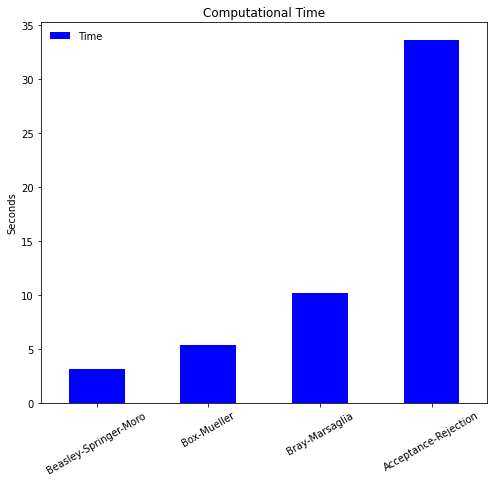

In [8]:
df.plot(kind="bar",color="blue",figsize=(8,7),rot=30)
plt.legend(frameon=False)
plt.title("Computational Time")
plt.ylabel("Seconds")
plt.show()

Evidently, the inverse CDF approximation method of Beasley-Springer-Moro constitutes the most efficient algorithm to sample from the Normal distribution in terms of computational time. This is because it does not involve the evaluation of trigonometric functions and avoids many nested loops. The Box-Mueller algorithm is the second most efficient in computational time.